<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


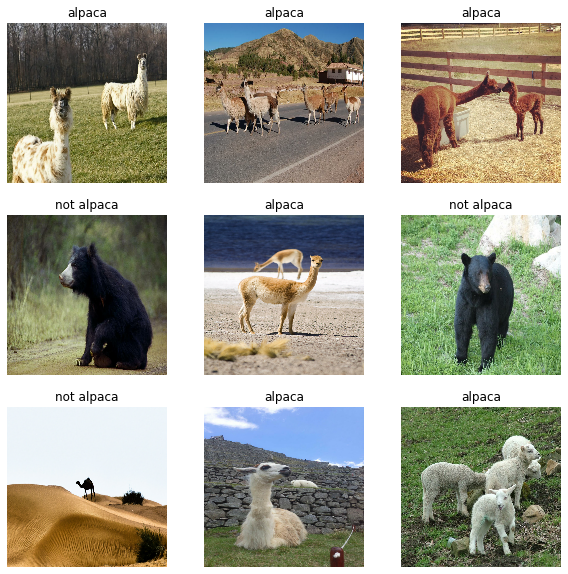

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [42]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

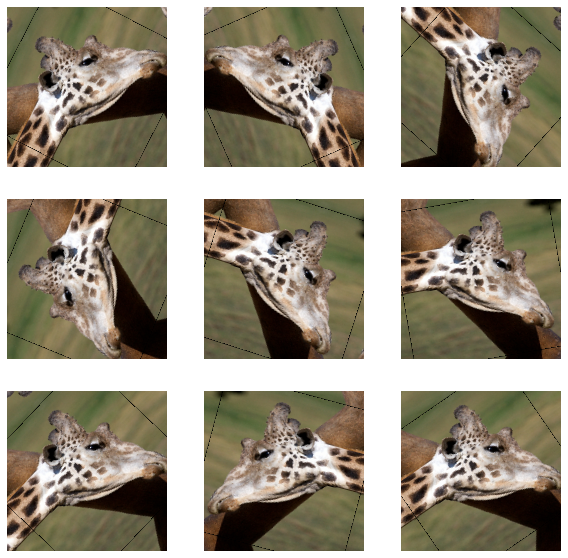

In [44]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [46]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [47]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_8_depthwise_BN (BatchNorm (None, 10, 10, 384)  1536        block_8_depthwise[0][0]          
__________________________________________________________________________________________________
block_8_depthwise_relu (ReLU)   (None, 10, 10, 384)  0           block_8_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________

In [48]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [49]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [50]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [51]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329965),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883611)],
 [('n02125311', 'cougar', 0.1654676), ('n02389026', 'sorrel', 0.10764261)],
 [('n02437312', 'Arabian_camel', 0.2923283),
  ('n02437616', 'llama', 0.27713484)],
 [('n03944341', 'pinwheel', 0.31154886), ('n03047690', 'clog', 0.052500293)],
 [('n02454379', 'armadillo', 0.73107153),
  ('n01990800', 'isopod', 0.038719974)],
 [('n02437312', 'Arabian_camel', 0.25663644),
  ('n02422106', 'hartebeest', 0.12122728)],
 [('n02437616', 'llama', 0.6612557),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.82735676),
  ('n02134418', 'sloth_bear', 0.02925945)],
 [('n01518878', 'ostrich', 0.9267562),
  ('n02002724', 'black_stork', 0.0017766367)],
 [('n01518878', 'ostrich', 0.94954586),
  ('n02018795', 'bustard', 0.0028661634)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.2429446), ('n02412080', 'ram', 

In [62]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [63]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [65]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 990ms/step - loss: 0.7985 - accuracy: 0.5573 - val_loss: 0.6256 - val_accuracy: 0.6000
Epoch 2/5
9/9 [==============================] - 8s 845ms/step - loss: 0.6416 - accuracy: 0.5916 - val_loss: 0.5008 - val_accuracy: 0.7077
Epoch 3/5
9/9 [==============================] - 8s 867ms/step - loss: 0.5507 - accuracy: 0.7252 - val_loss: 0.4076 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 8s 855ms/step - loss: 0.4945 - accuracy: 0.7290 - val_loss: 0.4092 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 8s 868ms/step - loss: 0.4531 - accuracy: 0.7595 - val_loss: 0.3481 - val_accuracy: 0.7385


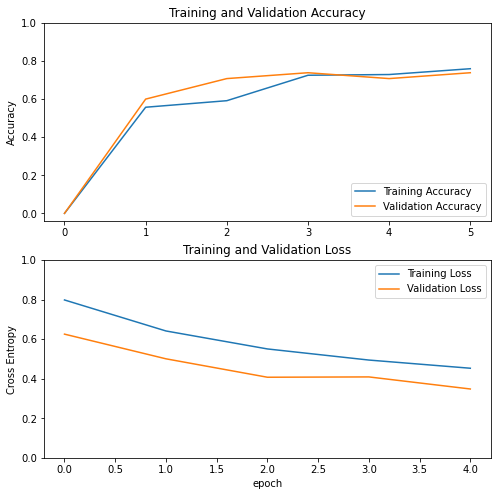

In [67]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
class_names

['alpaca', 'not alpaca']

In [75]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [77]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.6181 - accuracy: 0.6947 - val_loss: 0.3617 - val_accuracy: 0.9385
Epoch 6/10
9/9 [==============================] - 9s 991ms/step - loss: 0.4134 - accuracy: 0.7634 - val_loss: 0.2226 - val_accuracy: 0.9846
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.3000 - accuracy: 0.8588 - val_loss: 0.2298 - val_accuracy: 0.8308
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.2309 - accuracy: 0.9008 - val_loss: 0.1544 - val_accuracy: 0.9231
Epoch 9/10
9/9 [==============================] - 9s 1s/step - loss: 0.1790 - accuracy: 0.9313 - val_loss: 0.1069 - val_accuracy: 0.9385
Epoch 10/10
9/9 [==============================] - 9s 1s/step - loss: 0.1529 - accuracy: 0.9389 - val_loss: 0.0794 - val_accuracy: 0.9692


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [78]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

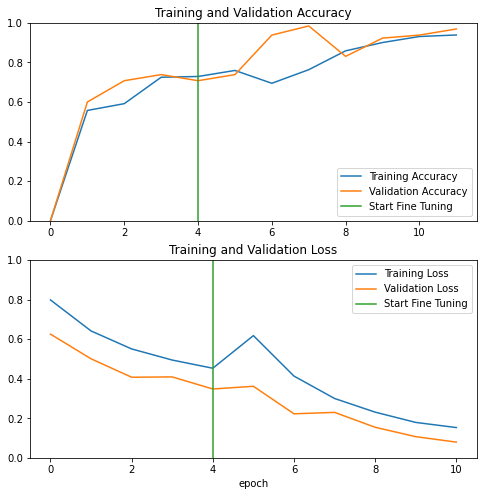

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()